In [72]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [73]:
%%appyter hide_code

{% do SectionField(
    name='primary',
    title='X2KTR (Expression to Kinases & Target Ranger)',
) %}

{% do DescriptionField(
    name='data_file_description',
    text='''
    Files should be a tsv/csv of the form:<br />
    <table class="table">
    <tr>
      <td>&nbsp;</td>
      <th>Patient 1 Tumor</th>
      <th>Patient 2 Tumor</th>
      <th>...</th>
    </tr>
    <tr>
      <th>Gene</th>
      <td>0</td>
      <td>200</td>
      <td>...</td>
    </tr>
    <tr>
      <th>Gene</th>
      <td>5</td>
      <td>180</td>
      <td>...</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    </table>''',
    section='primary',
) %}

{% set rna_file = FileField(
    name='rna_expr',
    label='RNA-seq tumor expression',
    description='Gene on the rows, samples on the columns',
    default='CPTAC3_HNSCC_tumor_counts.tsv',
    required=False,
    examples={
        'CPTAC3_HNSCC_tumor_counts.tsv': 'https://minio.dev.maayanlab.cloud/x2k-tr/CPTAC3_HNSCC_tumor_counts.tsv',
    },
    section='primary',
) %}


{% set prot_file = FileField(
    name='prot_expr',
    label='Protein tumor expression',
    description='Gene on the rows, samples on the columns',
    default='HNSCC_proteomics_tumor.tsv',
    required=False,
    examples={
        'HNSCC_proteomics_tumor.tsv': 'https://minio.dev.maayanlab.cloud/x2k-tr/HNSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.tsv',
    },
    section='primary',
) %}

{% set impute_protein_expr = BoolField(
    name='impute_protein_expr',
    label='Impute protein expression (averages)',
    default=True,
    section='primary',
) %}

{% set phospho_file = FileField(
    name='phospho_expr',
    label='Tumor protein phosphorylation',
    description='Phosphoproteins on the rows, samples on the columns',
    default='HSNCC_phospho_observed.tsv',
    required=False,
    examples={
        'HSNCC_phospho_observed.tsv': 'https://minio.dev.maayanlab.cloud/x2k-tr/HSNCC_phospho_observed.tsv',
    },
    section='primary',
) %}

{% set impute_phospho_expr = BoolField(
    name='impute_phospho_expr',
    label='Impute protein phosphorylation (averages)',
    default=True,
    section='primary',
) %}

{% set meta_file = FileField(
    name='meta',
    label='Sample metadata',
    description='Samples on the rows, metadata on the columns',
    default='HNSCC_meta.txt',
    required=True,
    examples={
        'HNSCC_meta.txt': 'https://minio.dev.maayanlab.cloud/x2k-tr/HNSCC_meta.txt',
    },
    section='primary',
) %}

{% set membrane_screener_ = TabField(
    name='membrane_screener',
    label='Prioritize membrane genes',
    description='Use a list of genes that encode cell surface proteins to identify membrane. Only human currently supported.',
    default='Yes',
    section='primary',
    choices={
     'Yes': [
        ChoiceField(
                name='membrane_list',
                label='Membrane gene list',
                description='Choose the source for list of membrane genes.',
                choices={
                    'COMPARTMENTS + Human Protein Atlas': "'https://appyters.maayanlab.cloud/storage/Tumor_Gene_Target_Screener/surfaceome.csv'",
                    'Membranome': "'https://lomize-group-membranome.herokuapp.com/proteins?fileFormat=csv'",
                },
                default='COMPARTMENTS + Human Protein Atlas',
            ),
    ],
    'No': [
    ]
    }
) %}

{% set membrane_screener_list = membrane_screener_.value[0] %}

{% set membrane_screener = membrane_screener_.raw_value == 'Yes' %}

{% set normalize_to_background = BoolField(
    name='normalize_to_background',
    label='Normalize to background distribution (Target Identification)',
    default=True,
    section='primary',
) %}

## X2KTR
### Expression to Kinases & Target Ranger
Finding targets and key to cell signaling pathways that are uniquely activated in tumor cells while absent from all normal tissues and cell types remains a significant challenge. In addition, targets identified from analyzing transcriptomics do not ensure that the targets are also expressed at the protein level. Furthermore, heterogeneity within the tumor, across patients of the same cancer type, and across cancers, underscore the need for subtype-specific personalized target identification. Our analysis and workflows address some of these challenges by combining phosphoproteomics, proteomics, and transcriptomics with comprehensive normal tissue and cell type atlases to identify safer targets for cancer subtypes. 

In [74]:
from helpers import *
import os
import re
import qnorm
from tqdm import tqdm
import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, display, Markdown, FileLink
from matplotlib.gridspec import GridSpec
from matplotlib_venn import venn2
from maayanlab_bioinformatics.normalization import zscore_normalize, log2_normalize
from scipy.stats import zscore
from maayanlab_bioinformatics.dge import limma_voom_differential_expression
from maayanlab_bioinformatics.harmonization.ncbi_genes import ncbi_genes_lookup

os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

lookup = ncbi_genes_lookup(organism='Mammalia/Homo_sapiens')

import sys
import contextlib
@contextlib.contextmanager
def suppress_output(stdout=True, stderr=True, dest=os.devnull):
    ''' Usage:
    with suppress_output():
        print('hi')
    '''
    dev_null = open(dest, 'a')
    if stdout:
        _stdout = sys.stdout
        sys.stdout = dev_null
    if stderr:
        _stderr = sys.stderr
        sys.stderr = dev_null
    try:
        yield
    finally:
        if stdout:
            sys.stdout = _stdout
        if stderr:
            sys.stderr = _stderr

In [75]:
%%appyter code_exec
has_rna_file = {{ rna_file }} != ''
has_prot_file = {{ prot_file }} != ''
has_phospho_file = {{ phospho_file }} != ''
has_meta_file = {{ meta_file }} != ''

```python
has_rna_file = 'CPTAC3_HNSCC_tumor_counts.tsv' != ''
has_prot_file = 'HNSCC_proteomics_tumor.tsv' != ''
has_phospho_file = 'HSNCC_phospho_observed.tsv' != ''
has_meta_file = 'HNSCC_meta.txt' != ''
```

In [76]:
%%appyter code_exec

if has_rna_file:
    rna_df = read_table({{ rna_file }})
    rna_filename = {{ rna_file }}.split('.')[0]
if has_prot_file:
    prot_df = read_table({{ prot_file }})
    prot_filename = {{ prot_file }}.split('.')[0]
if has_phospho_file:
    phospho_df = read_table({{ phospho_file }})
    phospho_filename = {{ phospho_file }}.split('.')[0]
if has_meta_file:
    meta_df = read_table({{ meta_file }})

```python
if has_rna_file:
    rna_df = read_table('CPTAC3_HNSCC_tumor_counts.tsv')
    rna_filename = 'CPTAC3_HNSCC_tumor_counts.tsv'.split('.')[0]
if has_prot_file:
    prot_df = read_table('HNSCC_proteomics_tumor.tsv')
    prot_filename = 'HNSCC_proteomics_tumor.tsv'.split('.')[0]
if has_phospho_file:
    phospho_df = read_table('HSNCC_phospho_observed.tsv')
    phospho_filename = 'HSNCC_phospho_observed.tsv'.split('.')[0]
if has_meta_file:
    meta_df = read_table('HNSCC_meta.txt')
```

#### Cluster Samples from RNA-seq Expression for Target Identification

Grouping patients together who share similar vectors of expression may lead to identification of targets specific to smaller subsets of patients. Clustering is performed on the 1000 most variable genes using the leiden community algorthim [1]. 

In [77]:
rna_df.index = rna_df.index.map(lambda g: g.split('.')[0])
rna_df.index = rna_df.index.map(lambda g: lookup(g) if lookup(g) else g)

/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/giacomomarino/X2KTR/venv/lib/python3.10/site-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


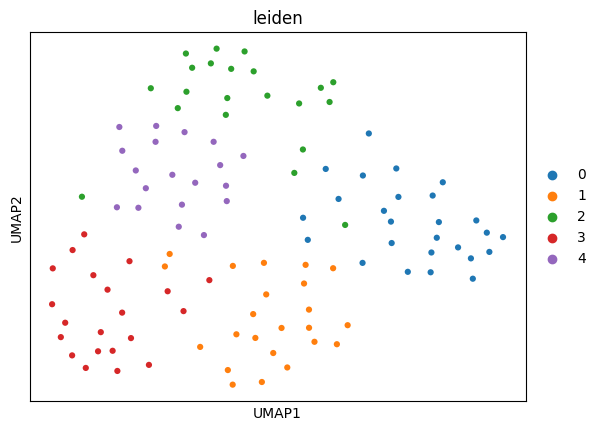

In [78]:
import scanpy as sc
adata = sc.AnnData(log2_normalize(rna_df.T.values), dtype="int")
adata.var['gene_names'] = rna_df.index.values
adata.obs['samples'] = rna_df.columns.values
# Sort genes by variance
adata.var['var_rank'] = (-np.var(adata.X, axis=0, dtype="float")).argsort()
adata = adata[:, adata.var.var_rank < 1000]

min_dist=0.01
n_neighbors=15
resolution=1
# UMAP
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=n_neighbors)  # create neighborhood graph
sc.tl.umap(adata, min_dist=min_dist, spread=5, alpha=0.1)  # embed umap based on neighborhood graph
sc.tl.leiden(adata, resolution=resolution)  # clustering
sc.pl.umap(adata, color="leiden", size=80)

In [79]:
leiden_df = pd.DataFrame([adata.obs['leiden'], adata.obs['samples']]).T.set_index('samples')
clusters = list(leiden_df['leiden'].unique())
leiden_df.value_counts()

leiden
0         26
1         23
2         21
3         21
4         19
Name: count, dtype: int64

In [80]:
%%appyter markdown
{% if membrane_screener %}
## Load Membrane Proteins for Screening
{% if membrane_screener_list.raw_value == 'Membranome' %}
Membrane proteins are ideal targets, we can get these from [Membranome](https://membranome.org/) among other places.
{% else %}
Membrane proteins are ideal targets. This membrane/surface protein filter was created from the intersection of two data sources:
[COMPARTMENTS](https://compartments.jensenlab.org/About) knowledge predictions for human genes where a filter was applied for "Plasma membrane" and "Cell surface" subcellular localization with a confidence score greater than or equal to 3 and [Human Protein Atlas](https://www.proteinatlas.org/) membrane proteins where a filter was applied for "Evidence at protein level" and removal of genes with "Low tissue specificity."
{% endif %}
{% endif %}


## Load Membrane Proteins for Screening

Membrane proteins are ideal targets. This membrane/surface protein filter was created from the intersection of two data sources:
[COMPARTMENTS](https://compartments.jensenlab.org/About) knowledge predictions for human genes where a filter was applied for "Plasma membrane" and "Cell surface" subcellular localization with a confidence score greater than or equal to 3 and [Human Protein Atlas](https://www.proteinatlas.org/) membrane proteins where a filter was applied for "Evidence at protein level" and removal of genes with "Low tissue specificity."



In [81]:
%%appyter code_exec
{% if membrane_screener %}
proteins = pd.read_csv({{ membrane_screener_list }})
{% if membrane_screener_list.raw_value == 'Membranome' %}
proteins = proteins[proteins['species_name_cache'] == 'Homo sapiens']
{% endif %}
membrane_proteins = list(proteins['genename'].map(lookup).dropna().values)
{% endif %}

```python
proteins = pd.read_csv('https://appyters.maayanlab.cloud/storage/Tumor_Gene_Target_Screener/surfaceome.csv')
membrane_proteins = list(proteins['genename'].map(lookup).dropna().values)
```

### Cell Surface Target Identification
By comparing the inputted samples with processed RNA-seq from several atlases containing healthy expression (GTEx [2], ARCHS4 [3], and Tabula Sapiens [4]), we identify genes that are highly expressed in the target cells while lowly expressed across normal human cell types, and tissues.

In [82]:
targets = {}
bgs = {'GTEx': 'gtex-gene-stats.tsv', 'ARCHS4': 'archs4-gene-stats.tsv', 'TS': 'ts_10x_cell-ontology-class_donors_tissue-labels_v1.tsv'}
for bg in bgs:
    print('Finding Targets using', bg)
    df_bg_stats = pd.read_csv(f"https://appyters.maayanlab.cloud/storage/Tumor_Gene_Target_Screener/{bgs[bg]}", sep='\t', index_col=[0,1])
    df_bg_genes = df_bg_stats.unstack().index.map(lambda idx: lookup(idx.partition('.')[0]))
    df_bg_stats = df_bg_stats.unstack().groupby(df_bg_genes, observed=True).median().stack()
    df_bg_expr = df_bg_stats.loc[(slice(None), ['25%', '50%', '75%']), :].unstack()
    common_index = list(set(rna_df.index) & set(df_bg_expr.index))
    target_distribution = df_bg_expr.loc[common_index, :].median(axis=1)
    expr_df = rna_df.loc[common_index, :]
    expr_df.reset_index(inplace=True)
    expr_df.drop_duplicates(subset='gene_id', inplace=True)
    expr_df.set_index('gene_id', inplace=True, drop=True)
    df_expr_norm = qnorm.quantile_normalize(expr_df.loc[common_index, :], target=target_distribution)
    df_bg_expr_norm = qnorm.quantile_normalize(df_bg_expr.loc[common_index, :], target=target_distribution)
    for cluster in tqdm(clusters):
        if cluster not in targets: targets[cluster] = {}
        cluster_samples = list(leiden_df[leiden_df['leiden'] == cluster].index.values)
        with suppress_output():
            df_bg_expr_norm.columns = df_bg_expr_norm.columns.to_flat_index().map(lambda s: ', '.join(s))
            dge = limma_voom_differential_expression(
                df_bg_expr_norm, df_expr_norm[cluster_samples],
                voom_design=True,
            )
            targets[cluster][bg] = dge[(dge['adj.P.Val'] < 0.01) & (dge['t'] > 0)].sort_values('t', ascending=False).index.values 

Finding Targets using GTEx


100%|██████████| 5/5 [00:45<00:00,  9.20s/it]


Finding Targets using ARCHS4


100%|██████████| 5/5 [03:35<00:00, 43.02s/it]


Finding Targets using TS


100%|██████████| 5/5 [04:17<00:00, 51.50s/it]


```python
YlGnBu = cm.get_cmap('YlGnBu_r', 8)
cmap = {"None":YlGnBu(0), "ARCHS4": YlGnBu(1), "GTEx":YlGnBu(2), "TS": YlGnBu(4), "ARCHS4-GTEx":YlGnBu(3),  "ARCHS4-TS": YlGnBu(5), "GTEx-TS": YlGnBu(6), "All": YlGnBu(7)}
top_targets_n = 100
target_list = []
for cluster in targets:
    for bg in targets[cluster]:
        target_list.extend(list(filter(lambda g: g in membrane_proteins, targets[cluster][bg][:top_targets_n])))
data1, data2, data3 = [], [], []
similarity = []
target_list = list(set(target_list))
for gene in target_list:
    a = [1 if gene in targets[c]['ARCHS4'][:top_targets_n] else 0 for c in clusters]
    g = [2 if gene in targets[c]['GTEx'][:top_targets_n] else 0 for c in clusters]
    l = [4 if gene in targets[c]['TS'][:top_targets_n] else 0 for c in clusters]
    data1.append(a)
    data2.append(g)
    data3.append(l)
    similarity.append(np.dot(np.dot(np.array(a), np.array(g)), np.array(l)))
data = np.add(np.add(data1, data2), data3)
membrane_target_mat = pd.DataFrame(data)
membrane_target_mat.columns = [f"Cluster {c}" for c in clusters]
membrane_target_mat.index = target_list
membrane_target_mat['count'] = membrane_target_mat.sum(axis=1)
membrane_target_mat = membrane_target_mat[membrane_target_mat['count'] >= 7]
membrane_target_mat = membrane_target_mat.rename_axis('Membrane Target').sort_values(by = ['count', 'Membrane Target'], ascending = [False, True]).drop('count', axis=1)
h = membrane_target_mat.shape[0]
g = sns.clustermap(membrane_target_mat, figsize=(4,0.3*h+2*(h<15)), cmap=YlGnBu, cbar_pos=None, dendrogram_ratio=0.1-(h<40)*0.01*(h-30), row_cluster=False, xticklabels=True, yticklabels=True, standard_scale=1)
g.ax_row_dendrogram.legend(handles=[Rectangle((0, 0), 0, 0, color=val, label=key) for key, val in cmap.items()],
                                title='Background', loc='upper right')
plt.show()
g.savefig(f'figures/{rna_filename}_membrane_target_matrix.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{rna_filename}_membrane_target_matrix.svg', dpi=300, bbox_inches='tight')
membrane_target_mat.to_csv(f'results/{rna_filename}_membrane_target_mat.csv')
display(FileLink(f'results/{rna_filename}_membrane_target_mat.csv', result_html_prefix='Download Membrane Target Matrix: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.png', result_html_prefix='Membrane Target Matrix PNG: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.svg', result_html_prefix='Membrane Target Matrix SVG: '))
```

<string>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


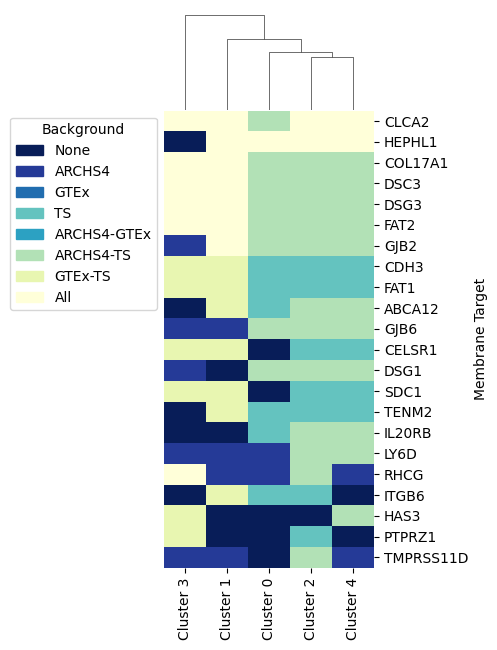

/Users/giacomomarino/X2KTR/results/CPTAC3_HNSCC_tumor_counts_membrane_target_mat.csv

/Users/giacomomarino/X2KTR/figures/CPTAC3_HNSCC_tumor_counts_membrane_target_matrix.png

/Users/giacomomarino/X2KTR/figures/CPTAC3_HNSCC_tumor_counts_membrane_target_matrix.svg

In [83]:
%%appyter code_exec
YlGnBu = cm.get_cmap('YlGnBu_r', 8)
cmap = {"None":YlGnBu(0), "ARCHS4": YlGnBu(1), "GTEx":YlGnBu(2), "TS": YlGnBu(4), "ARCHS4-GTEx":YlGnBu(3),  "ARCHS4-TS": YlGnBu(5), "GTEx-TS": YlGnBu(6), "All": YlGnBu(7)}

top_targets_n = 100
target_list = []
for cluster in targets:
    for bg in targets[cluster]:
        target_list.extend(list(filter(lambda g: g in membrane_proteins, targets[cluster][bg][:top_targets_n])))
data1, data2, data3 = [], [], []
similarity = []
target_list = list(set(target_list))

for gene in target_list:
    a = [1 if gene in targets[c]['ARCHS4'][:top_targets_n] else 0 for c in clusters]
    g = [2 if gene in targets[c]['GTEx'][:top_targets_n] else 0 for c in clusters]
    l = [4 if gene in targets[c]['TS'][:top_targets_n] else 0 for c in clusters]
    data1.append(a)
    data2.append(g)
    data3.append(l)
    similarity.append(np.dot(np.dot(np.array(a), np.array(g)), np.array(l)))

data = np.add(np.add(data1, data2), data3)

membrane_target_mat = pd.DataFrame(data)
membrane_target_mat.columns = [f"Cluster {c}" for c in clusters]
membrane_target_mat.index = target_list

membrane_target_mat['count'] = membrane_target_mat.sum(axis=1)
membrane_target_mat = membrane_target_mat[membrane_target_mat['count'] >= 7]
membrane_target_mat = membrane_target_mat.rename_axis('Membrane Target').sort_values(by = ['count', 'Membrane Target'], ascending = [False, True]).drop('count', axis=1)

h = membrane_target_mat.shape[0]



g = sns.clustermap(membrane_target_mat, figsize=(4,0.3*h+2*(h<15)), cmap=YlGnBu, cbar_pos=None, dendrogram_ratio=0.1-(h<40)*0.01*(h-30), row_cluster=False, xticklabels=True, yticklabels=True, standard_scale=1)
g.ax_row_dendrogram.legend(handles=[Rectangle((0, 0), 0, 0, color=val, label=key) for key, val in cmap.items()],
                                title='Background', loc='upper right')

plt.show()

g.savefig(f'figures/{rna_filename}_membrane_target_matrix.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{rna_filename}_membrane_target_matrix.svg', dpi=300, bbox_inches='tight')
membrane_target_mat.to_csv(f'results/{rna_filename}_membrane_target_mat.csv')

display(FileLink(f'results/{rna_filename}_membrane_target_mat.csv', result_html_prefix='Download Membrane Target Matrix: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.png', result_html_prefix='Membrane Target Matrix PNG: '))
display(FileLink(f'figures/{rna_filename}_membrane_target_matrix.svg', result_html_prefix='Membrane Target Matrix SVG: '))

100%|██████████| 11561/11561 [00:01<00:00, 8785.07it/s]


Text(0.5, 0, '% with values')

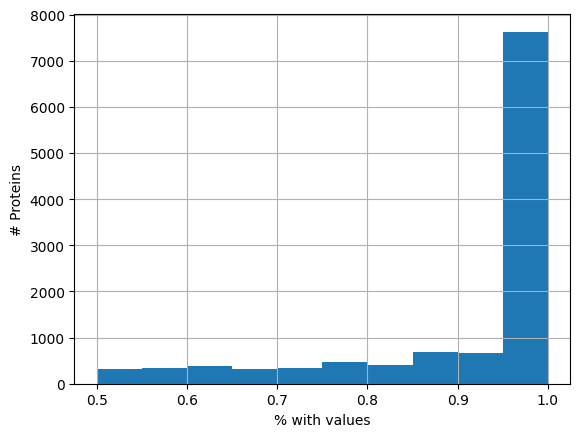

In [236]:
percentages = []
idx = []
i = 0
for _, row in tqdm(prot_df.iterrows(), total=len(prot_df)):
    value_counts = row.astype(float).isna().value_counts()
    pr = value_counts[0]/len(row)
    if pr > 0.8:
        idx.append(i)
    percentages.append(pr)
    i += 1
ax = pd.Series(percentages).hist()
ax.set_ylabel("# Proteins")
ax.set_xlabel("% with values")

In [237]:
prot_df_imputed = prot_df.iloc[idx].T.fillna(prot_df.iloc[idx].mean(axis=1)).T.astype(float)
zscored_prot = zscore(prot_df_imputed, axis=0)

In [238]:
top_var_proteins = zscored_prot.var(axis=1).sort_values(ascending=False)
top_var_proteins_list = top_var_proteins.index[:100].tolist()
top_var_proteins.head(10)

idx
SPRR4      0.406859
KHDC1L     0.376113
LCE3E      0.353840
LCE3D      0.339177
DEFA3      0.311464
MAGEA10    0.301103
KRT75      0.284838
SPRR2F     0.282892
SPRR5      0.275516
CHGA       0.274381
dtype: float64

/Users/giacomomarino/X2KTR/figures/HNSCC_proteomics_tumor_top_var_proteins_heatmap.png

/Users/giacomomarino/X2KTR/figures/HNSCC_proteomics_tumor_top_var_proteins_heatmap.svg

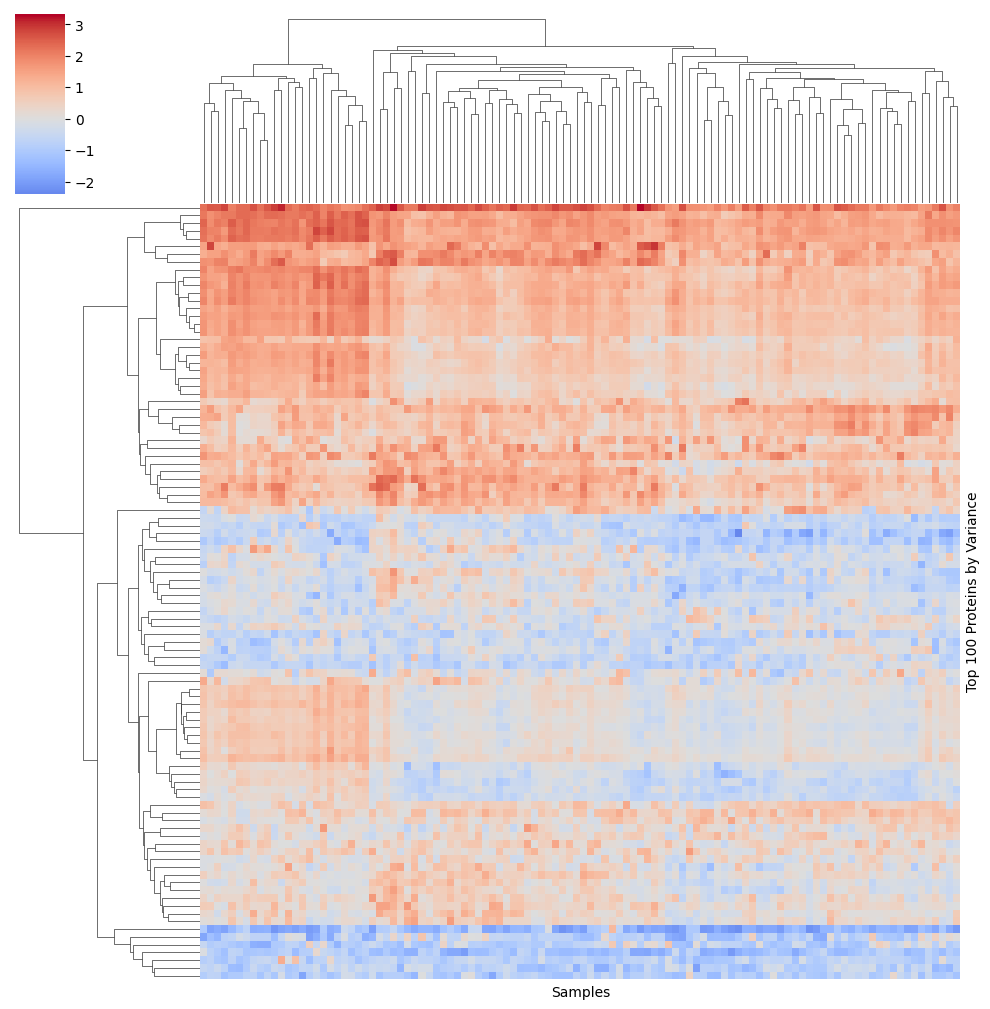

In [239]:

g = sns.clustermap(zscored_prot.loc[top_var_proteins_list], cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
ax = g.ax_heatmap
ax.set_ylabel('Top 100 Proteins by Variance')
ax.set_xlabel('Samples')
g.savefig(f'figures/{prot_filename}_top_var_proteins_heatmap.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{prot_filename}_top_var_proteins_heatmap.svg', dpi=300, bbox_inches='tight')
display(FileLink(f'figures/{prot_filename}_top_var_proteins_heatmap.png', result_html_prefix='Most Variable Proteins Heatmap PNG: '))
display(FileLink(f'figures/{prot_filename}_top_var_proteins_heatmap.svg', result_html_prefix='Most Variable Proteins Heatmap SVG: '))

In [288]:
rna_df_log2_zscore = zscore(log2_normalize(rna_df), axis=0)
rna_df_log2_zscore

,C3N-01756,C3L-03378,C3N-01943,C3N-01755,C3N-04275,C3N-00829,C3N-01339,C3N-00825,C3N-01758,C3N-01946,...,C3N-01645,C3N-01752,C3L-04844,C3N-03027,C3N-03487,C3N-01944,C3N-03226,C3N-03042,C3N-02713,C3N-03008
gene_id,,,,,,,,,,,,,,,,,,,,,
TSPAN6,1.796435,1.578512,1.774191,1.495287,1.655893,1.604899,2.099140,1.629982,1.578108,1.345639,...,1.672232,1.663536,1.678784,1.787580,1.377348,1.728998,1.530523,1.694655,1.488071,1.584374
TNMD,-0.816342,-0.148399,-0.754881,-0.833114,-0.541952,-0.768085,-0.522788,-0.768402,-0.758115,-0.755680,...,-0.777393,-0.744295,-0.755597,-0.399055,-0.738969,-0.760225,-0.302135,-0.738008,-0.568797,-0.481825
DPM1,1.444216,1.570212,1.700823,1.661829,1.538788,1.475367,1.842218,1.661310,1.708765,1.658608,...,1.804099,1.608452,1.781937,1.646952,1.723145,1.648578,1.684452,1.675671,1.492901,1.754257
SCYL3,1.581513,1.636596,1.613347,1.614195,1.651818,1.569177,1.571443,1.520272,1.493641,1.652024,...,1.470522,1.660380,1.672648,1.508885,1.696761,1.528095,1.607174,1.508728,1.523462,1.566363
FIRRM,1.702079,1.658092,1.499380,1.752833,1.330640,1.540529,1.480355,1.521886,1.286361,1.425712,...,1.502893,1.517374,1.486432,1.492571,1.460620,1.410069,1.356604,1.266118,1.472731,1.549418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288600,-0.816342,-0.334556,-0.145243,-0.132195,-0.541952,-0.768085,-0.522788,-0.768402,-0.289806,0.090372,...,-0.546153,-0.744295,-0.755597,-0.538304,-0.354201,-0.383646,-0.026654,-0.738008,-0.804832,-0.723248
ENSG00000288601,-0.816342,-0.795707,-0.754881,-0.833114,-0.780446,-0.768085,-0.765169,-0.768402,-0.758115,-0.755680,...,-0.777393,-0.527107,-0.755597,-0.776352,-0.738969,-0.760225,-0.773074,-0.738008,-0.804832,-0.723248
C8orf44-SGK3,-0.216938,0.242363,0.462975,-0.303678,0.214055,0.388722,0.317930,0.136292,0.690425,0.661808,...,0.362466,0.577257,0.489587,0.430949,0.510600,0.322942,0.490860,0.197450,0.303981,0.153665


In [171]:
chea_res = {}
for patient in tqdm(rna_df_log2_zscore.columns.values):
    chea_res[patient] = {}
    down_rows = rna_df_log2_zscore[patient].astype(float).sort_values(ascending=True)[:500]
    up_rows = rna_df_log2_zscore[patient].astype(float).sort_values(ascending=False)[:500]

    down_genes = list(set(down_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))
    up_genes = list(set(up_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))

    chea_down = get_chea3_results(down_genes, f'{patient}_down_genes')
    chea_up = get_chea3_results(up_genes, f'{patient}_up_genes')
    chea_res[patient]['down'] = chea_down
    chea_res[patient]['up'] = chea_up

100%|██████████| 110/110 [07:54<00:00,  4.32s/it]


100%|██████████| 55271/55271 [00:05<00:00, 9348.19it/s]


Text(0.5, 0, '% with values')

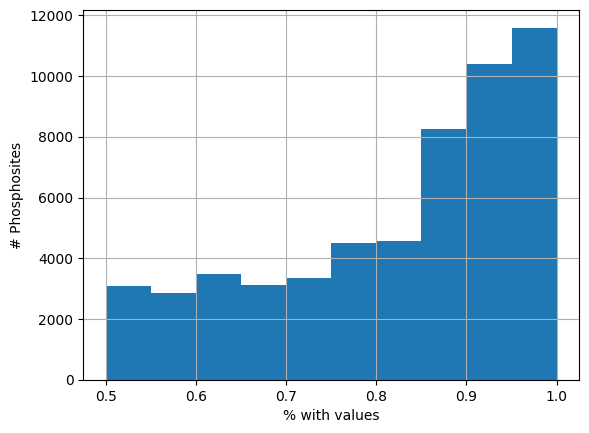

In [172]:
percentages = []
idx = []
i = 0
for _, row in tqdm(phospho_df.iterrows(), total=len(phospho_df)):
    value_counts = row.astype(float).isna().value_counts()
    pr = value_counts[0]/len(row)
    if pr > 0.8:
        idx.append(i)
    percentages.append(pr)
    i += 1
ax = pd.Series(percentages).hist()
ax.set_ylabel("# Phosphosites")
ax.set_xlabel("% with values")

In [267]:
phospho_df_imputed = phospho_df.iloc[idx].T.fillna(phospho_df.iloc[idx].mean(axis=1)).T.astype(float)
zscored_phospho = zscore(phospho_df_imputed.astype(float), axis=0, nan_policy='omit')
zscored_phospho.head(10)

,C3N-04277,C3N-01339,C3N-02333,C3N-04611,C3N-00829,C3N-03487,C3N-02279,C3N-03849,C3N-04280,C3N-03619,...,C3N-03042,C3L-00995,C3N-03012,C3N-03928,C3N-03620,C3L-04791,C3N-01645,C3N-01337,C3N-03876,C3N-03433
ENSG00000000419.12|ENSP00000360644.5|S21|RRELEVRSPRQNKYS|1,-0.752563,-0.752944,-0.757349,-0.752837,-0.757445,-0.747228,-0.754814,-0.748505,-0.756922,-0.754270,...,-0.752347,-0.756117,-0.767048,-0.904199,-0.761072,-0.753648,-0.752607,-0.755930,-0.754134,-0.780305
ENSG00000000457.14|ENSP00000356746.4|S533|SEEWPDWSEPEEPEN|1,-0.196269,-0.195176,-0.200325,-0.316854,-0.406850,-0.190065,-0.206538,-0.189115,-0.323347,-0.355665,...,-0.205909,-0.157125,-0.205575,-0.044953,-0.111902,-0.195368,-0.219228,-0.207357,-0.194001,-0.290234
ENSG00000000457.14|ENSP00000356746.4|S569|TLDVEESSWDDCEPS|1,0.399266,0.241272,0.636496,0.297737,0.381667,0.351485,0.379518,0.304289,0.360800,0.231829,...,0.376849,0.552198,0.261389,0.336370,0.407683,0.754289,0.244544,0.319122,0.298393,0.415393
ENSG00000000457.14|ENSP00000356746.4|S651|ERPLKVPSELGLGEE|1,-0.626380,-0.626426,-0.466297,-0.626426,-0.705709,-0.620848,-0.627084,-0.621619,-0.631063,-0.627146,...,-0.625196,-0.629452,-0.673787,-0.644437,-0.634237,-0.627014,-0.626003,-0.629120,-0.627080,-0.755286
ENSG00000000457.14|ENSP00000356746.4|S707|VPKKDDVSPVMQFSS|1,1.508036,1.552585,1.700375,1.538400,1.252547,1.462790,1.393778,1.444269,1.845811,1.482621,...,1.620155,1.559772,1.570983,1.540603,1.583723,1.453485,1.124681,1.494520,1.626996,1.704174
ENSG00000000938.13|ENSP00000363117.3|S46|TKARPASSFAHIPNY|1,0.187380,-0.057723,0.117722,0.236275,0.120112,0.005796,0.129818,-0.057238,0.114756,0.194895,...,0.128279,0.136981,0.115012,0.116635,0.117363,-0.059791,0.519535,0.408797,0.009921,0.119219
ENSG00000000938.13|ENSP00000363117.3|Y412|RLIKDDEYNPCQGSK|1,-1.950455,-1.954007,-1.956814,-1.952890,-1.960316,-1.946991,-1.967382,-1.953063,-1.951734,-1.849119,...,-1.959425,-1.958582,-1.976094,-1.958902,-1.965146,-1.955816,-1.954499,-1.373338,-1.960293,-1.955025
ENSG00000000971.16|ENSP00000356399.4|S1079|RVRYQCRSPYEMFGD|1,-0.969277,-0.970231,-0.974348,-0.969942,-0.975060,-0.964281,-0.974183,-0.966425,-0.973079,-0.972600,...,-0.970723,-0.973659,-0.985780,-0.975962,-0.978904,-0.971135,-0.970045,-0.973720,-0.994605,-0.972697
ENSG00000000971.16|ENSP00000356399.4|S411|RKFVQGKSIDVACHP|1,-1.127848,-1.129222,-1.133127,-1.128799,-1.134290,-1.123099,-1.134697,-1.125878,-1.131242,-0.928953,...,-1.130510,-1.132835,-1.145828,-1.134818,-1.138294,-1.130272,-1.129146,-1.188835,-1.132009,-1.131454
ENSG00000000971.16|ENSP00000356399.4|S921|TCYMGKWSSPPQCEG|1,0.684962,0.147401,0.490022,0.495146,0.493468,0.500453,0.506184,0.504163,0.485612,0.500756,...,0.502942,0.494374,0.490286,0.489114,0.491094,0.496535,0.497288,0.495993,0.500198,0.491466


In [272]:
zscored_phospho_var = zscored_phospho.var(axis=1).sort_values(ascending=False)
zscored_phospho_var_list = zscored_phospho_var.index[:100].tolist()
zscored_phospho_var.head(10)

ENSG00000096696.14|ENSP00000369129.3|S2551|FDQYRSGSLSLTQFA|1    0.291467
ENSG00000096696.14|ENSP00000369129.3|S2553|QYRSGSLSLTQFADM|1    0.228032
ENSG00000084110.11|ENSP00000261208.3|S635|IPESRPLSPTAFSLQ|1     0.205537
ENSG00000101605.13|ENSP00000348821.4|S58|SAAHRRESEAFRRAS|1      0.198078
ENSG00000101605.13|ENSP00000348821.4|S220|QSTASRQSVVSKQAT|1     0.193058
ENSG00000081248.11|ENSP00000355192.3|S1575|PEICRTVSGDLAAEE|1    0.191524
ENSG00000036448.10|ENSP00000262113.4|S951|CKSYEEISDDERFKI|1     0.181293
ENSG00000092054.13|ENSP00000347507.3|S1550|ALEEAEASLEHEEGK|1    0.177861
ENSG00000101306.11|ENSP00000365152.4|S143|QAAARRGSPAFLHSP|1     0.174600
ENSG00000038427.16|ENSP00000265077.3|S2941|NKTDGQVSGEAIKMF|1    0.169260
dtype: float64

/Users/giacomomarino/X2KTR/figures/HSNCC_phospho_observed_top_var_phosphosites_heatmap.png

/Users/giacomomarino/X2KTR/figures/HSNCC_phospho_observed_top_var_phosphosites_heatmap.svg

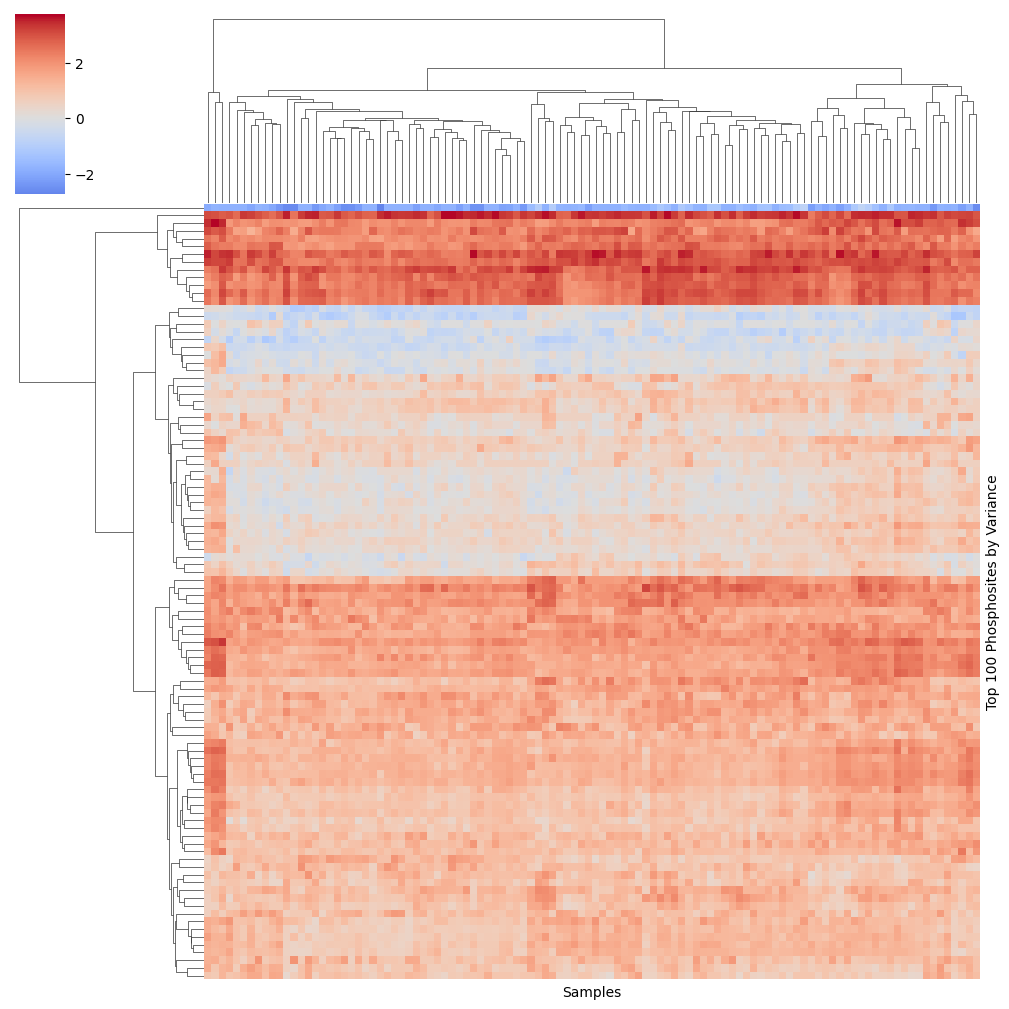

In [273]:
g = sns.clustermap(zscored_phospho.loc[zscored_phospho_var_list], cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
ax = g.ax_heatmap
ax.set_ylabel('Top 100 Phosphosites by Variance')
ax.set_xlabel('Samples')
g.savefig(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.png', dpi=300, bbox_inches='tight')
g.savefig(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.svg', dpi=300, bbox_inches='tight')
display(FileLink(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.png', result_html_prefix='Most Variable Phosphosites Heatmap PNG: '))
display(FileLink(f'figures/{phospho_filename}_top_var_phosphosites_heatmap.svg', result_html_prefix='Most Variable Phosphosites Heatmap SVG: '))

In [194]:
kea_res = {}
for patient in tqdm(zscored_phospho.columns):
    kea_res[patient] = {}
    down_rows = zscored_phospho[patient][(zscored_phospho[patient] < -1.96)].sort_values(ascending=True)[:500]
    up_rows = zscored_phospho[patient][(zscored_phospho[patient] > 1.96)].sort_values(ascending=False)[:500]
    
    down_phopshosites = list(set(down_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))
    up_phopshosites = list(set(up_rows.index.map(lambda g: lookup(g.split('.')[0]) if lookup(g.split('.')[0]) else g.split('.')[0])))

    up_kinases = get_kea3_results(up_phopshosites, f'{patient}_up_phosphosites')
    down_kinases = get_kea3_results(down_phopshosites, f'{patient}_down_phosphosites')
    kea_res[patient]['up'] = up_kinases
    kea_res[patient]['down'] = down_kinases

100%|██████████| 108/108 [03:31<00:00,  1.96s/it]


In [200]:
ids = list(chea_res.keys())

n_TFs = 20

up_TFs = {}
up_intermediates = {}
with tqdm(total=len(ids)) as pbar:
    pbar.set_description("Augmenting TFs from up-genes...")
    for id in ids:
        up_TFs[id] = chea_res[id]['up'].astype(float).sort_values(by='Score', ascending=True).index[:n_TFs].to_list()
        up_intermediates[id] = geneshot_set_augment(gene_list=up_TFs[id])
        pbar.update(1)
up_TFs = pd.DataFrame(up_TFs)
up_intermediates = pd.DataFrame(up_intermediates)
up_TFs.to_csv(f"results/up_TFs.csv", index=False)
up_intermediates.to_csv(f"results/up_intermediates.csv", index=False)

dn_TFs = {}
dn_intermediates = {}
with tqdm(total=len(ids)) as pbar:
    pbar.set_description("Augmenting TFs from down-genes...")
    for id in ids:
        dn_TFs[id] = chea_res[id]['down'].astype(float).sort_values(by='Score', ascending=True).index[:n_TFs].to_list()
        dn_intermediates[id] = geneshot_set_augment(gene_list=dn_TFs[id])
        pbar.update(1)
dn_TFs = pd.DataFrame(dn_TFs)
dn_intermediates = pd.DataFrame(dn_intermediates)
dn_TFs.to_csv(f"results/dn_TFs.csv", index=False)
dn_intermediates.to_csv(f"results/dn_intermediates.csv", index=False)

Augmenting TFs from down-genes...: 100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


In [201]:
# Compute normalized kinase enrichment scores
up_kinases = {}
dn_kinases = {}
x2k_up = {}
x2k_dn = {}

with tqdm(total=len(ids)) as pbar:
    pbar.set_description("Computing RNA-seq derived KEA scores...")
    for id in ids:
        up_geneset = list(set(list(up_TFs[id]) + list(up_intermediates[id])))
        dn_geneset = list(set(list(dn_TFs[id]) + list(dn_intermediates[id])))
        up_results = get_kea3_results(up_geneset)
        dn_results = get_kea3_results(dn_geneset)
        up_kinases[id] = up_results.astype(float).sort_values(by="Score", ascending=True).index.to_list()
        dn_kinases[id] = dn_results.astype(float).sort_values(by="Score", ascending=True).index.to_list()
        if len(x2k_up) == 0:
            KINASES = up_results.Score.index.to_list()
        x2k_up[id] = up_results.Score.loc[KINASES]
        x2k_dn[id] = dn_results.Score.loc[KINASES]
        pbar.update(1)

pd.DataFrame(up_kinases).to_csv(f"results/up_kinases.csv", index=False)
pd.DataFrame(dn_kinases).to_csv(f"results/dn_kinases.csv", index=False)
x2k_up = pd.DataFrame(x2k_up, index=KINASES)
x2k_dn = pd.DataFrame(x2k_dn, index=KINASES)
x2k_up.to_csv(f"results/up_x2k_zscores.csv")
x2k_dn.to_csv(f"results/dn_x2k_zscores.csv")

Computing RNA-seq derived KEA scores...: 100%|██████████| 110/110 [03:07<00:00,  1.70s/it]


/var/folders/99/6s5jl0js53zgzvw97txs2knc0000gn/T/ipykernel_84964/2424231110.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds_reversed = cm.get_cmap('Reds').reversed()


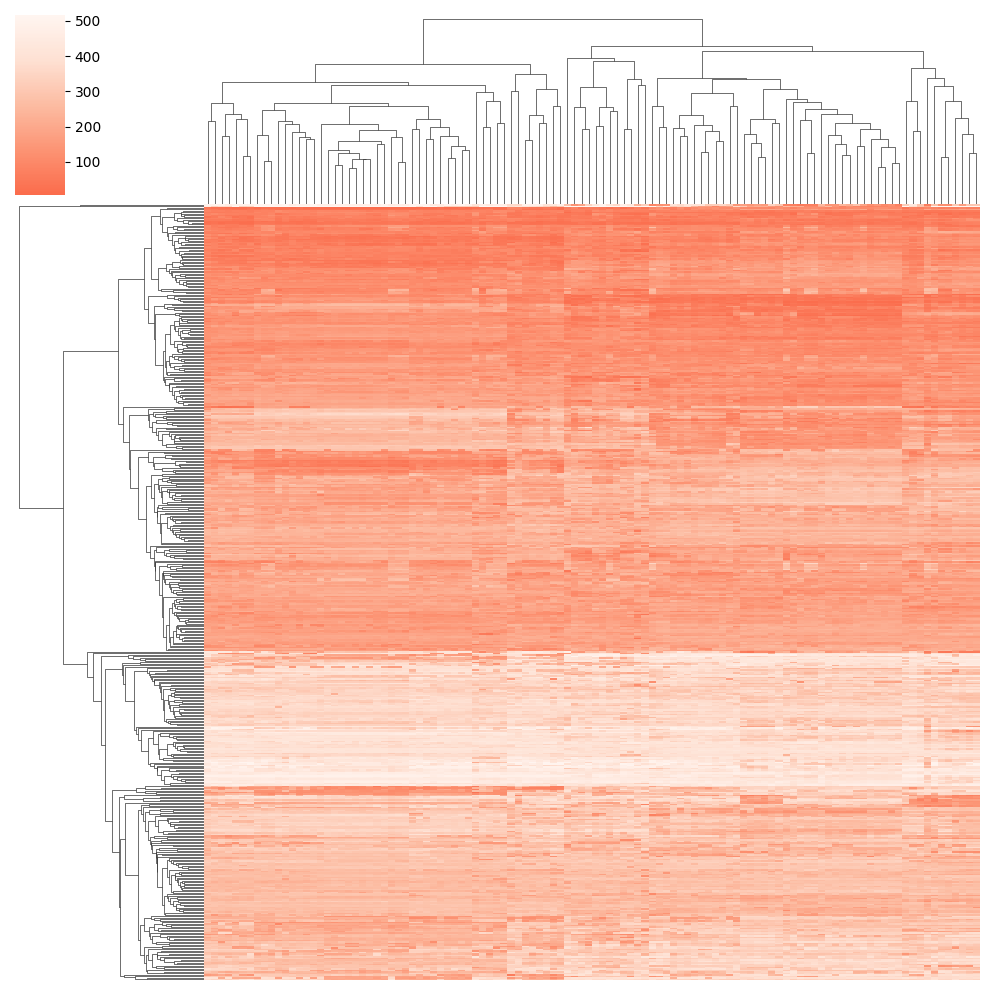

In [285]:
reds_reversed = cm.get_cmap('Reds').reversed()
g = sns.clustermap(x2k_up.astype(float), cmap=reds_reversed, center=0, xticklabels=False, yticklabels=False)

### Kinases enriched in both X2K and phospho- pipelines

In [210]:

rank_threshold = 30

rec_kinases = {}
for id  in kea_res:
    up = x2k_up[id].astype(float).sort_values(ascending=True).index.to_list()
    up_phospho = kea_res[id]['up'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(up[:rank_threshold]) & set(up_phospho[:rank_threshold]))
up_up_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
up_up_df.to_csv(f"results/recovered_up_phospho_up_genes.csv", index=False)

rec_kinases = {}
for id  in kea_res:
    dn = x2k_dn[id].astype(float).sort_values(ascending=True).index.to_list()
    dn_phospho = kea_res[id]['down'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(dn[:rank_threshold]) & set(dn_phospho[:rank_threshold]))
dn_dn_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
dn_dn_df.to_csv(f"results/recovered_dn_phospho_dn_genes.csv", index=False)

rec_kinases = {}
for id in kea_res:
    dn = x2k_dn[id].astype(float).sort_values(ascending=True).index.to_list()
    up_phospho = kea_res[id]['up'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(dn[:rank_threshold]) & set(up_phospho[:rank_threshold]))
up_dn_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
up_dn_df.to_csv(f"results/recovered_up_phospho_dn_genes.csv", index=False)

rec_kinases = {}
for id in kea_res:
    up = x2k_up[id].astype(float).sort_values(ascending=True).index.to_list()
    dn_phospho = kea_res[id]['down'].astype(float).sort_values(by='Score', ascending=True).index.to_list()
    rec_kinases[id] = list(set(up[:rank_threshold]) & set(dn_phospho[:rank_threshold]))
dn_up_df = pd.DataFrame.from_dict(rec_kinases, orient='index').T
dn_up_df.to_csv(f"results/recovered_dn_phospho_up_genes.csv", index=False)

In [224]:
display(up_up_df.head())
display(FileLink(f"results/recovered_up_phospho_up_genes.csv", result_html_prefix='Download Recovered Kinases (up-up):'))

,C3N-04277,C3N-01339,C3N-02333,C3N-04611,C3N-00829,C3N-03487,C3N-02279,C3N-03849,C3N-04280,C3N-03619,...,C3N-03042,C3L-00995,C3N-03012,C3N-03928,C3N-03620,C3L-04791,C3N-01645,C3N-01337,C3N-03876,C3N-03433
0,SRC,CSNK2A1,PRKCA,MAPK3,MAPK14,SRC,MAPK14,MAPK14,SRC,SRC,...,SRC,PRKCA,SRC,SRC,MAPK1,SRC,MAPK14,SRC,PRKCA,MAPK14
1,PRKCA,SRPK1,SRC,MAPK1,CSNK2A1,PRKCA,SRC,CSNK2A1,PRKCA,PRKCA,...,PRKCA,SRC,PRKCA,PRKCA,CLK1,MAPK3,PRKCA,PRKCA,CSNK2A1,CSNK2A1
2,MAPK3,MAPK3,PRKCD,CDK9,MAPK3,PTK2,PRKCA,AKT1,PRKCD,AKT1,...,MAPK3,MAPK3,PTK2,PTK2,CDK9,PDPK1,SRC,MAPK3,MAPK3,CSNK2A2
3,AKT1,PRKCD,MAPK1,EGFR,PRKCD,MAPK3,MAPK3,MAPK1,AKT1,MAPK1,...,PRKCD,AKT1,PRKCD,AKT1,PRKDC,MAPK1,CSNK2A1,PRKCD,PRKCD,SRPK1
4,EGFR,PLK1,EGFR,ABL1,MAPK1,PRKCD,PRKCD,CDK9,MAPK1,EGFR,...,AKT1,MAPK1,AKT1,MAPK1,GSK3B,CDK9,MAPK3,AKT1,MAPK1,MAPK3


/Users/giacomomarino/X2KTR/results/recovered_up_phospho_up_genes.csv

In [225]:
display(dn_dn_df.head())
display(FileLink(f"results/recovered_dn_phospho_dn_genes.csv", result_html_prefix='Download Recovered Kinases (down-down):'))

,C3N-04277,C3N-01339,C3N-02333,C3N-04611,C3N-00829,C3N-03487,C3N-02279,C3N-03849,C3N-04280,C3N-03619,...,C3N-03042,C3L-00995,C3N-03012,C3N-03928,C3N-03620,C3L-04791,C3N-01645,C3N-01337,C3N-03876,C3N-03433
0,CSNK2A1,MAP3K7,MAP3K7,CSNK2A1,MAP3K7,ARAF,MAP3K7,ARAF,MAP3K7,MAP3K7,...,CSNK2A1,MAP3K7,MAP3K7,MAP3K7,MAP3K7,CSNK1E,MTOR,MAP3K7,CSNK2A1,MAP3K7
1,ATR,MTOR,MTOR,CSNK2A2,MTOR,CSNK2A1,MTOR,CSNK2A1,CSNK2A1,MTOR,...,ATR,MTOR,MTOR,MTOR,MTOR,CSNK2A1,CSNK2A1,MTOR,ATR,MTOR
2,MAPK1,CSNK2A1,CSNK2A1,ATR,CSNK2A1,CDK1,CSNK2A1,CDK1,ATR,CSNK2A1,...,MAPK1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,ATR,CSNK2A2,CSNK2A1,MAPK1,CSNK2A1
3,CDK9,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,...,CDK2,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,MAPK1,CDK2,MAPK1
4,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,...,ABL1,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,CDK2,ABL1,CDK2


/Users/giacomomarino/X2KTR/results/recovered_dn_phospho_dn_genes.csv

In [226]:
display(up_dn_df.head())
display(FileLink(f"results/recovered_up_phospho_dn_genes.csv", result_html_prefix='Download Recovered Kinases (up-down):'))

,C3N-04277,C3N-01339,C3N-02333,C3N-04611,C3N-00829,C3N-03487,C3N-02279,C3N-03849,C3N-04280,C3N-03619,...,C3N-03042,C3L-00995,C3N-03012,C3N-03928,C3N-03620,C3L-04791,C3N-01645,C3N-01337,C3N-03876,C3N-03433
0,ARAF,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,...,ARAF,CSNK2A1,ARAF,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1,CSNK2A1
1,CSNK2A1,CDK1,CSNK2A2,CSNK2A2,CSNK2A2,CDK1,CSNK2A2,CSNK2A2,CDK1,CDK1,...,CSNK2A1,CDK1,CSNK2A1,CSNK2A2,CDK1,CSNK2A2,CSNK2A2,CSNK2A2,CSNK2A2,CSNK2A2
2,CSNK2A2,CSNK2A2,MAPK1,MAPK1,MAPK1,CSNK2A2,MAPK1,MAPK1,CSNK2A2,CSNK2A2,...,CSNK2A2,CSNK2A2,CSNK2A2,MAPK1,CSNK2A2,MAPK1,MAPK1,MAPK1,MAPK1,CDK6
3,CDK9,MAPK1,CDK2,CDK6,CDK6,MAPK1,CDK9,CDK6,CDK6,MAPK1,...,MAPK1,MAPK1,MAPK1,CDK2,MAPK1,CDK6,CDK9,CDK6,CDK9,MAPK1
4,CDK2,CDK9,ABL1,CDK9,CDK9,CDK2,CDK2,CDK9,MAPK1,CDK9,...,CDK6,CDK9,CDK2,ABL1,CDK9,CDK9,CDK2,CDK9,CDK2,CDK9


/Users/giacomomarino/X2KTR/results/recovered_up_phospho_dn_genes.csv

In [227]:
display(dn_up_df.head())
display(FileLink(f"results/recovered_dn_phospho_up_genes.csv", result_html_prefix='Download Recovered Kinases (down-up):'))

,C3N-04277,C3N-01339,C3N-02333,C3N-04611,C3N-00829,C3N-03487,C3N-02279,C3N-03849,C3N-04280,C3N-03619,...,C3N-03042,C3L-00995,C3N-03012,C3N-03928,C3N-03620,C3L-04791,C3N-01645,C3N-01337,C3N-03876,C3N-03433
0,SRC,AURKA,SRC,MAPK3,MAPK14,SRC,MAPK14,MAPK14,SRC,MAPK14,...,MAPK14,MAPK14,PRKACA,SRC,MAPK14,MAPK14,MAPK14,SRC,PRKCA,MAPK14
1,MAPK3,MTOR,MAPK3,MAPK1,AURKA,PTK2,SRC,CSNK2A1,MAPK3,SRC,...,SRC,SRC,SRC,AURKA,MAPK3,SRC,SRC,MAPK3,AURKA,AURKA
2,AKT1,CSNK2A1,MAPK1,ERBB2,MTOR,MAPK3,AURKA,MAPK3,AKT1,MAPK3,...,JAK2,MAPK3,MAPK3,MAPK3,PLK1,MAPK3,CSNK2A1,AKT1,CSNK2A1,MTOR
3,MAPK1,MAPK3,ERBB2,EGFR,CSNK2A1,AKT1,MAPK3,AKT1,MAPK1,AKT1,...,MAPK3,AKT1,AKT1,AKT1,MAPK1,PLK1,MAPK3,MAPK1,MAPK3,CSNK2A1
4,ERBB2,PLK1,EGFR,CDK2,MAPK3,MAPK1,AKT1,MAPK1,ERBB2,MAPK1,...,AKT1,MAPK1,MAPK1,MAPK1,HIPK2,MAPK1,MAPK1,ERBB2,PLK1,MAPK3


/Users/giacomomarino/X2KTR/results/recovered_dn_phospho_up_genes.csv